Cluster molecules and prioritize series from a high throughput screen.

Structure/activity data drawn from "A High Throughput Confirmatory Assay used to Identify Novel Compounds that Inhibit Mycobacterium Tuberculosis in the absence of Glycerol" (PubChem AID 449764).
https://pubchem.ncbi.nlm.nih.gov/bioassay/449764

Molecular descriptors calculated with KNIME-CDK version 1.5.600.v201711101057.

In [328]:
## setup cell
# chemistry functions
from rdkit import Chem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

# other libraries
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# display interactive plots in notebook
%matplotlib notebook

In [3]:
## load and process data
# load the initial dataset
screening_data = pd.read_csv("data/descriptors.csv")

# generate pIC90 for plotting; add placeholder value of 1 for inactive compounds
screening_data["pIC90"] = screening_data["IC90"].apply(lambda x: -1 * np.log10(x * 1e-6))
screening_data["pIC90"][screening_data["IC90"].isna()] = 1

# bin pIC90 for plotting
screening_data["activity levels"] = pd.cut(screening_data["pIC90"], bins = [0, 2, 4, 5, 100], labels = ["inactive", "low", "medium", "high"])

# generate pIC50 for plotting; add placeholder value of 1 for inactive compounds
screening_data["pIC50"] = screening_data["IC50"].apply(lambda x: -1 * np.log10(x * 1e-6))
screening_data["pIC50"][screening_data["IC50"].isna()] = 1

# bin pIC50 for plotting
screening_data["cytotoxicity"] = pd.cut(screening_data["pIC50"], bins = [0, 2, 4, 5, 100], labels = ["inactive", "low", "medium", "high"])

# convert SMILES strings into RDKit format
screening_data["mol"] = screening_data["SMILES"].apply(Chem.MolFromSmiles)

# calculate Morgan fingerprints for the molecules
screening_data["fingerprints"] = screening_data["mol"].apply(lambda x: GetMorganFingerprintAsBitVect(x, 2))

In [4]:
## calculate Tanimoto distance matrix between molecular fingerprints
# declare an array to hold the distances
distances = np.empty([len(screening_data["fingerprints"]), len(screening_data["fingerprints"])])

# calculate the distance array
for i in range(len(screening_data["fingerprints"])):
    for j in range(i, len(screening_data["fingerprints"])):
        distances[i, j] = 1 - DataStructs.TanimotoSimilarity(screening_data["fingerprints"][i], screening_data["fingerprints"][j])
        distances[j, i] = distances[i, j]
        
# flatten the distance array into a list as required by the clustering algorithm
# declare an empty list to hold the distances
distances_list = []

# iterate through the matrix row by row, taking just the diagonal and top half
for i in range(np.shape(distances)[0]):
    for j in range(i, np.shape(distances)[1]):
        distances_list.append(distances[i, j])

<IPython.core.display.Javascript object>


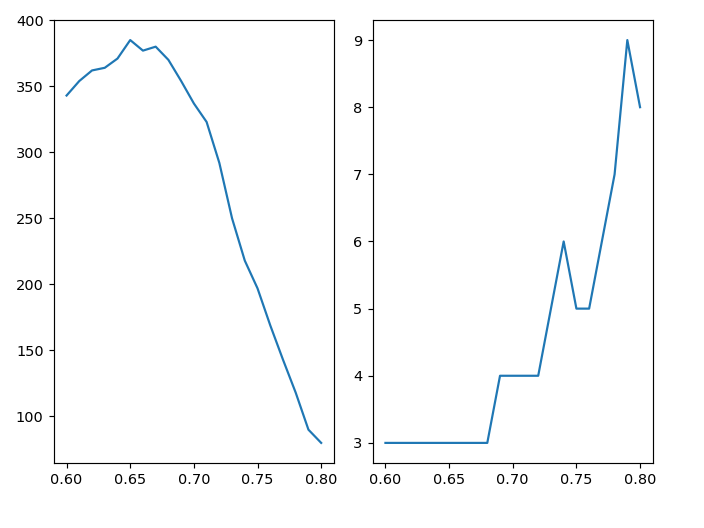

In [225]:
## tune clustering algorithm
# select some threshold values to try
epsilon = np.arange(0.6, 0.8, 0.01)

# declare an empty array to hold the number of clusters and median cluster size
n_clusters = np.empty([len(epsilon), 2])

# scan through threshold values
for i in range(len(epsilon)):
    # cluster by distance at each epsilon
    clusters = Butina.ClusterData(distances_list, nPts = np.shape(screening_data)[0], distThresh = epsilon[i], isDistData = True)
    
    # store the number of clusters generated and median cluster size
    # number of clusters (excluding singletons)
    n_clusters[i, 0] = len([len(cluster) for cluster in clusters if len(cluster) > 1])
    n_clusters[i, 1] = np.median([len(cluster) for cluster in clusters if len(cluster) > 1])
    
# plot number of clusters as a function of epsilon
fig, axs = plt.subplots(1, 2, tight_layout = True)
axs[0].plot(epsilon, n_clusters[:, 0])
axs[1].plot(epsilon, n_clusters[:, 1])
plt.show()

In [191]:
## cluster compounds
# cluster compounds to give a balance between number of clusters and cluster size
clusters = Butina.ClusterData(distances_list, nPts = np.shape(screening_data)[0], distThresh = 0.74, isDistData = True)

# store the cluster assignments back in the screening data dataframe
for cluster in range(len(clusters)):
    for compound in clusters[cluster]:
        screening_data.loc[compound, "cluster"] = cluster

In [313]:
# identify clusters with ten or more members
major_clusters = [group for group in screening_data.groupby("cluster").groups if len(screening_data.groupby("cluster").groups[group]) >= 10]

# subset the data to just the major clusters
clustered_data = screening_data.query("cluster in @major_clusters")

# generate median values of several metrics for the clusters
cluster_stats = clustered_data.groupby("cluster")["pIC90", "pIC50", "XLogP", "Molecular Weight", "Topological Polar Surface Area"].median()

# number of major clusters
len(major_clusters)

68

We have identified 68 clusters of reasonable size. The next step will be to prioritize the clustered compounds for future development.

<IPython.core.display.Javascript object>


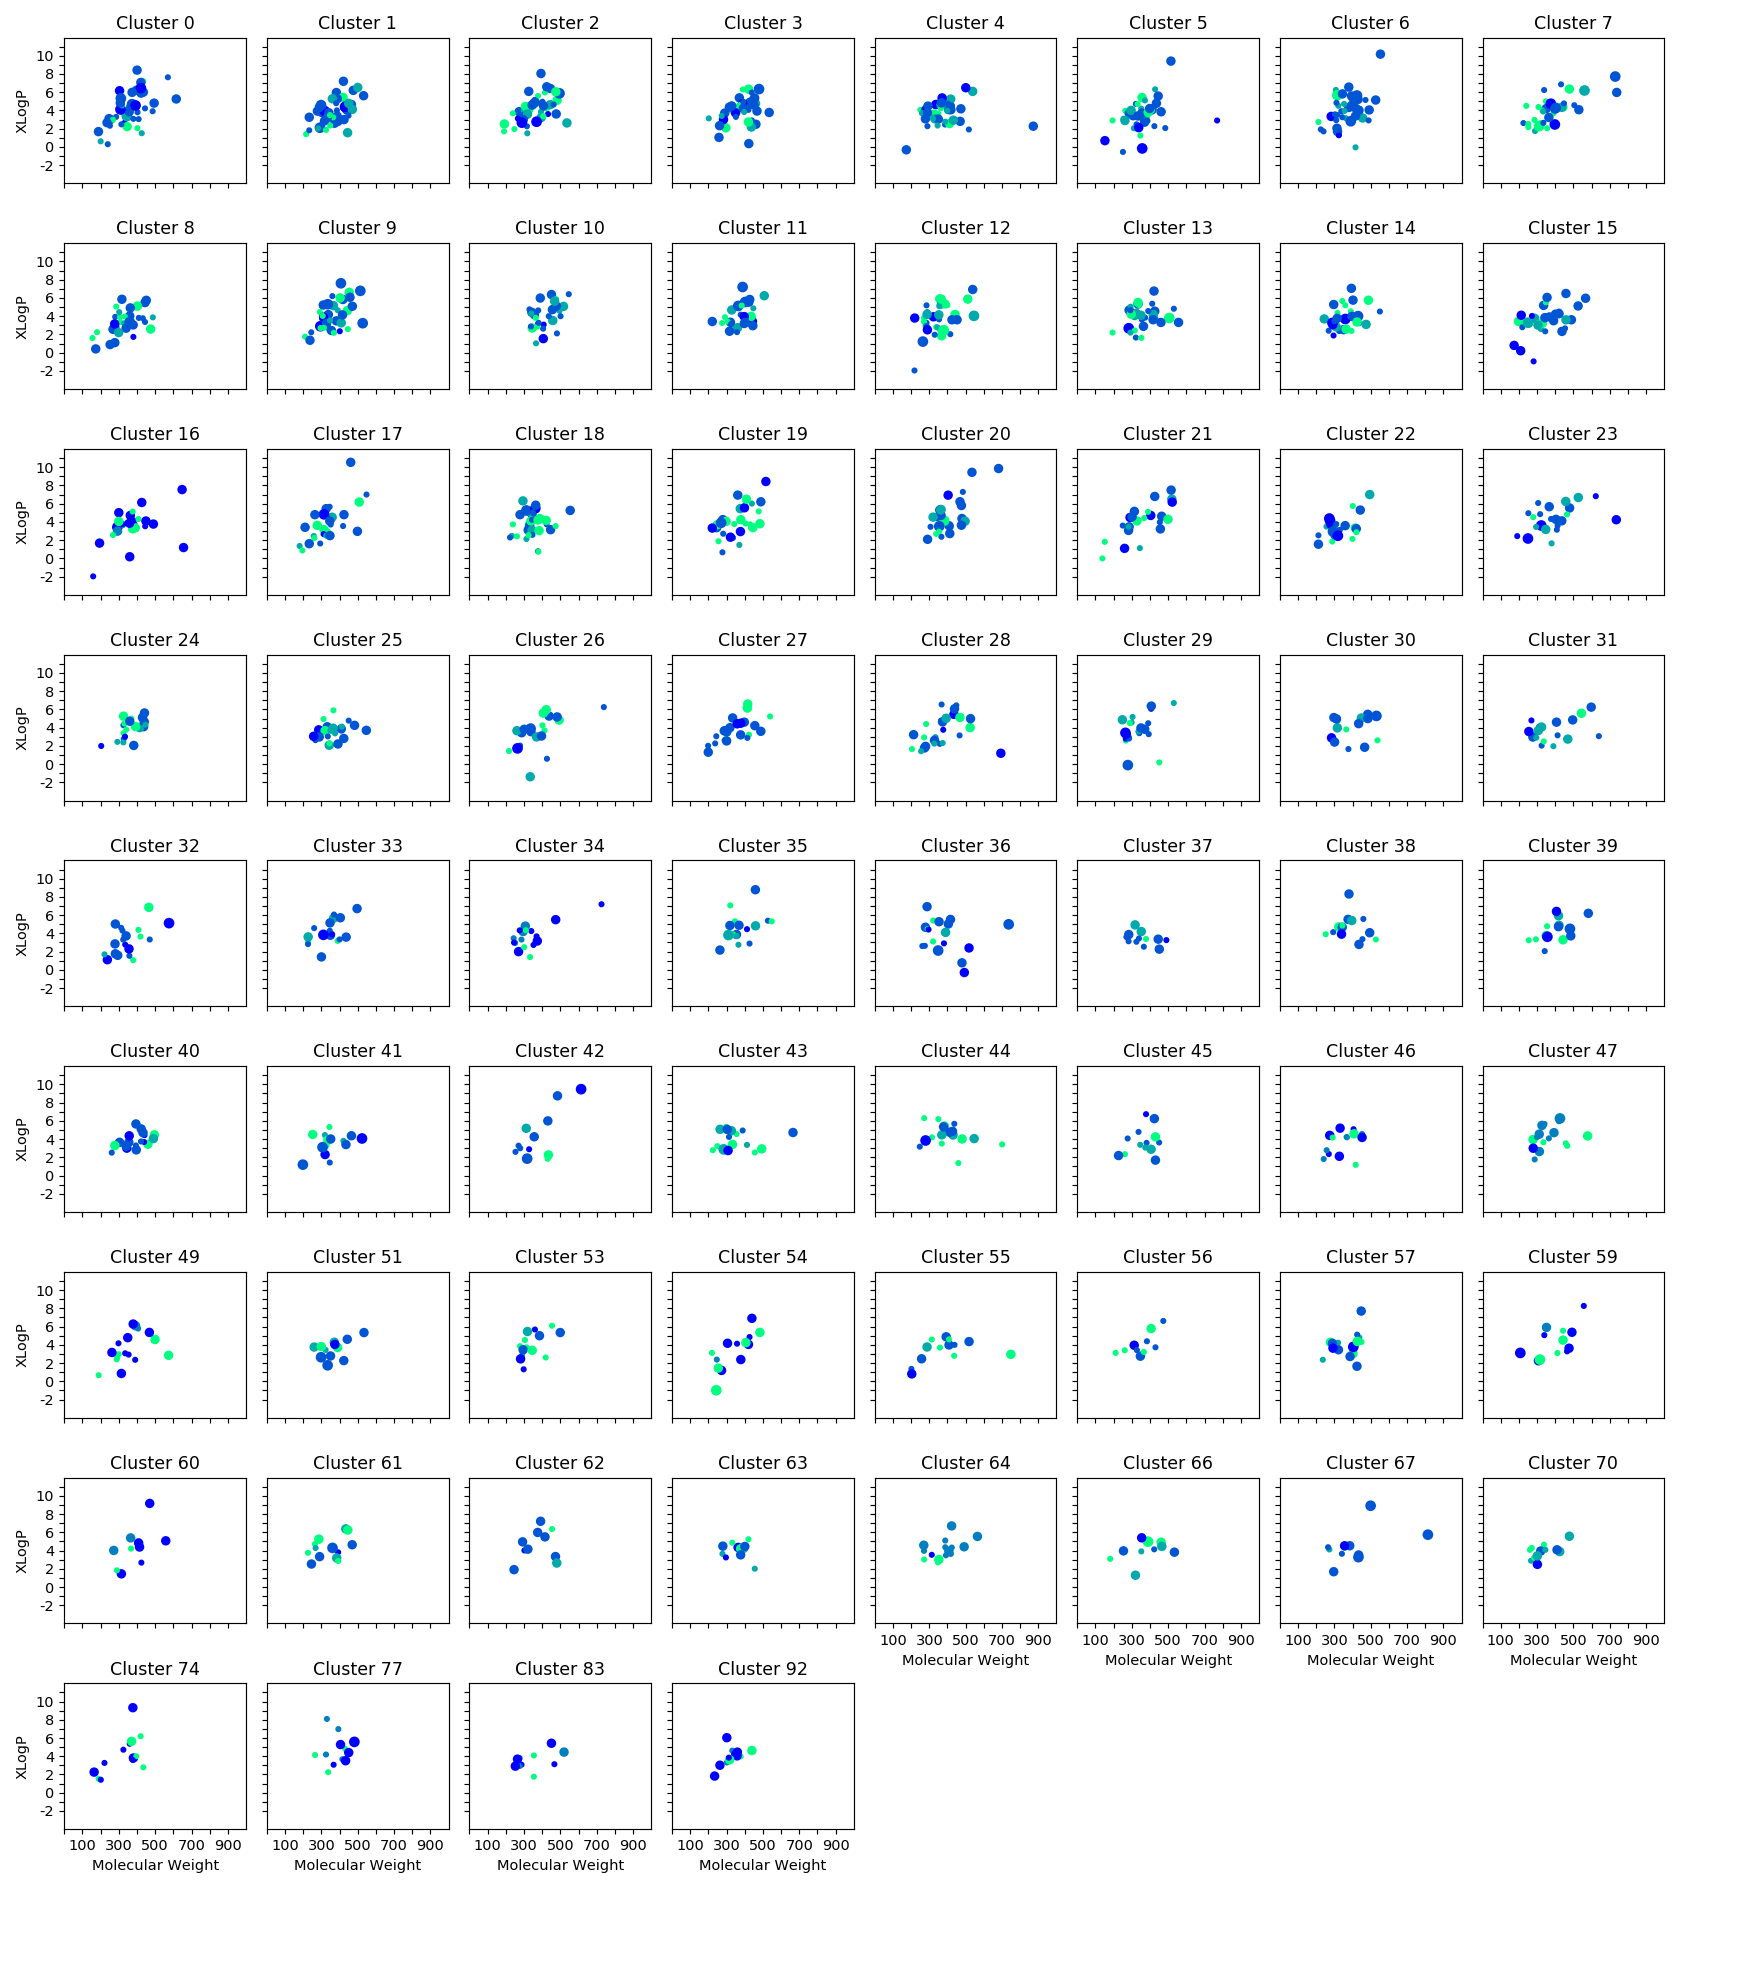

In [303]:
## plot clusters independently
# create a grid of axes
fig, axs = plt.subplots(9, 8, tight_layout = True, figsize = (16, 18))

# hide the empty subplots
axs[-1, -1].axis("off")
axs[-1, -2].axis("off")
axs[-1, -3].axis("off")
axs[-1, -4].axis("off")

# add a scatterplot for each cluster
for i in range(len(clustered_data["cluster"].unique())):
    
    # subset the clustered dataset to the current cluster
    cluster_data = clustered_data[clustered_data["cluster"] == np.sort(clustered_data["cluster"].unique())[i]]
    
    # add a scatterplot for the current cluster
    # save the scatterplot artist for legend generation
    axs.flat[i].scatter(cluster_data["Molecular Weight"], cluster_data["XLogP"], 
          c = cluster_data["activity levels"].cat.codes, s = (cluster_data["cytotoxicity"].cat.codes + 1) * 10, cmap = "winter_r")
    
    # add title to the subplot
    axs.flat[i].set_title("Cluster %s" %np.sort(clustered_data["cluster"].unique())[i])
    
    # set scale and tick marks
    axs.flat[i].set_xlim([0, 1000])
    axs.flat[i].set_xticks([i * 100 for i in range(10)])
    axs.flat[i].set_xticklabels([])
    axs.flat[i].set_ylim([-4, 12])
    axs.flat[i].set_yticks([i for i in range(-2, 12)])
    axs.flat[i].set_yticklabels([])
    
# label axis on the outside of the plot
# x-axis
for i in axs[8, 0:4]:
    i.set_xlabel("Molecular Weight")
    i.set_xticklabels([str(i * 100) if i%2 == 1 else "" for i in range(10)])
for i in axs[7, 4:8]:
    i.set_xlabel("Molecular Weight")
    i.set_xticklabels([str(i * 100) if i%2 == 1 else "" for i in range(10)])
# y-axis
for i in axs[:, 0]:
    i.set_ylabel("XLogP")
    i.set_yticklabels([str(i) if i%2 == 0 else "" for i in range(-2, 12)])
    
# add legends for color and size
#color_legend = fig.legend(scatter[3].legend_elements(prop = "colors")[0], cluster_data["activity levels"].cat.categories, 
#                          loc = [0.82, 0.20], title = "Activity")
#fig.add_artist(color_legend)
#size_legend = fig.legend(scatter[0].legend_elements(prop = "sizes")[0], cluster_data["cytotoxicity"].cat.categories, 
#                         loc = [0.82, 0.06], title = "Cytotoxicity")
#fig.add_artist(size_legend)


# display the figure
fig.show()

Old Cells

<IPython.core.display.Javascript object>


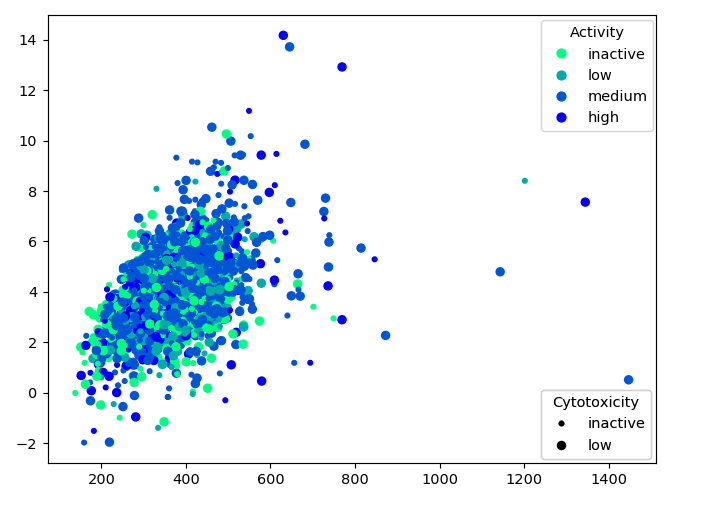

In [92]:
## plot singletons to look for particularly appealing compounds
# subset the series from the larger dataset
singletons = screening_data.query("cluster == -1")

# plot the singletons
fig, ax = plt.subplots(1, 1, tight_layout = True)
singletons_scatter = ax.scatter(singletons["Molecular Weight"], singletons["XLogP"], 
           c = singletons["activity levels"].cat.codes, s = (cluster_data["cytotoxicity"].cat.codes + 1) * 10, cmap = "winter_r")

# add color and size legends
color_legend = ax.legend(singletons_scatter.legend_elements(prop = "colors")[0], singletons["activity levels"].cat.categories, 
                          loc = [0.81, 0.74], title = "Activity")
fig.add_artist(color_legend)
size_legend = ax.legend(singletons_scatter.legend_elements(prop = "sizes")[0], singletons["cytotoxicity"].cat.categories, 
                         loc = [0.81, 0.01], title = "Cytotoxicity")
fig.add_artist(size_legend)

# display the figure
fig.show()

In [97]:
# pull out the particularly interesting singletons
# MW < 300, logP < 2, IC90 < 10 µM, cytotoxicity > 40 µM
singletons[singletons["Molecular Weight"] < 300][singletons["XLogP"] < 2][singletons["pIC90"] > 5][singletons["pIC50"] < 4.4]

,row ID,SMILES,Mtb Activity,IC90 Modifier,IC90,Vero Activity,IC50 Modifier,IC50,Aromatic Atoms Count,Bond Polarizabilities,...,pIC90,activity levels,pIC50,cytotoxicity,mol,fingerprints,cluster,pca1,pca2,pca3
62,856955,C1=CC=C(C(=C1)N=CC2=CC=CN2)O,Active,NaN,6.04,Active,>,40.0,11,12.912070,...,5.218963,high,4.39794,medium,<rdkit.Chem.rdchem.Mol object at 0x00000237E0A...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1,-3.785704,1.066600,0.828750
488,14738845,CC1=CC(=C(C2=C1C=CC(=N2)NN)O)C,Active,NaN,4.87,Active,>,40.0,10,14.211691,...,5.312471,high,4.39794,medium,<rdkit.Chem.rdchem.Mol object at 0x00000237E0A...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1,-2.509549,2.062450,0.509695
712,17409303,C/C(=C\C1=NC2=CC=CC=C2OC1=O)/O,Active,NaN,0.89,Inactive,NaN,NaN,10,14.032863,...,6.050610,high,1.00000,inactive,<rdkit.Chem.rdchem.Mol object at 0x00000237E0A...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1,-3.364881,1.051157,0.261063
1049,24779081,CC1=C(N=C(NC1=O)SCC(=O)NC2CCCCC2)C,Active,NaN,0.57,Inactive,NaN,NaN,6,29.793347,...,6.244125,high,1.00000,inactive,<rdkit.Chem.rdchem.Mol object at 0x00000237E0A...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1,-0.489074,2.166288,-1.611655
1309,24818725,C1=CC2=C(C=CC(=C2N=C1)O)F,Active,NaN,6.56,Inactive,NaN,NaN,10,9.082242,...,5.183096,high,1.00000,inactive,<rdkit.Chem.rdchem.Mol object at 0x00000237E0A...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",-1,-4.611644,0.740962,0.423713
1577,26671144,C1C(=C(C(=O)N1)C=NC2=CC=CC=C2O)O,Active,NaN,7.60,Active,>,40.0,6,13.870070,...,5.119186,high,4.39794,medium,<rdkit.Chem.rdchem.Mol object at 0x00000237E0A...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1,-2.537133,3.020272,0.705665
1845,49675007,C1=NC2=C(N1)C(=S)N=CN2,Active,NaN,5.19,Active,>,40.0,9,9.472828,...,5.284833,high,4.39794,medium,<rdkit.Chem.rdchem.Mol object at 0x00000237E0B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",-1,-4.313627,2.403271,1.268229
1851,49675981,C1COCCN1CCNC(=S)N/N=C/C2=CC=CS2,Active,NaN,7.16,Inactive,NaN,NaN,5,28.313726,...,5.145087,high,1.00000,inactive,<rdkit.Chem.rdchem.Mol object at 0x00000237E0B...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",-1,-0.417882,2.831591,-0.887469
2168,56463596,CNC1=C2C(=NC=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@...,Active,NaN,9.18,Inactive,NaN,NaN,9,24.914105,...,5.037157,high,1.00000,inactive,<rdkit.Chem.rdchem.Mol object at 0x00000237E0B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1,0.041023,4.781961,0.400541
2181,57260110,CN(C)N=NC1=C(NC=N1)C(=O)N,Active,NaN,8.38,Inactive,NaN,NaN,5,15.190070,...,5.076756,high,1.00000,inactive,<rdkit.Chem.rdchem.Mol object at 0x00000237E0B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1,-2.557885,4.288005,0.168823


<IPython.core.display.Javascript object>


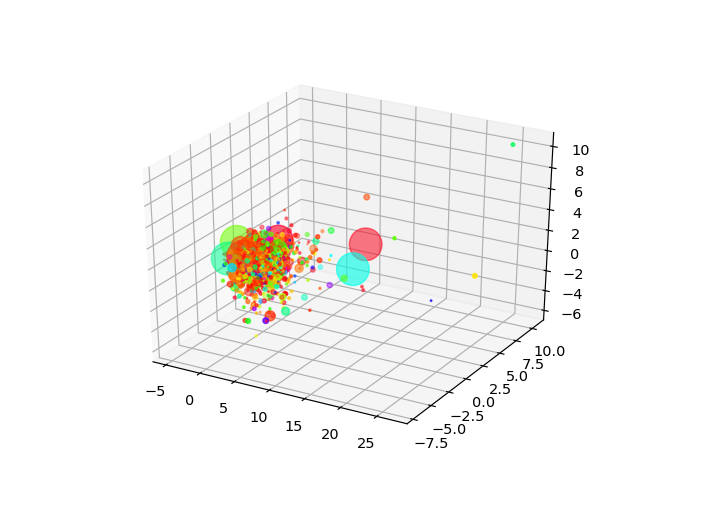

In [222]:
### visualize the clustering
## calculate principle components from the available molecular descriptors
# select descriptors from the dataframe
descriptors = screening_data[['Aromatic Atoms Count', 'Bond Polarizabilities', 'VABC Volume Descriptor', 
       'Hydrogen Bond Acceptors', 'Hydrogen Bond Donors', 'Rotatable Bonds Count', 'Topological Polar Surface Area',
       'Molecular Weight', 'XLogP', 'SP3 Character']]

# standardize features
descriptors = StandardScaler().fit_transform(descriptors.values)

# calculate first three principle components of descriptors; store back in dataframe
pca = PCA(n_components = 3)
screening_data[["pca1", "pca2", "pca3"]] = pd.DataFrame(pca.fit_transform(descriptors))

## plot the clustered compounds
# subset the series from the larger dataset
#clustered_data = screening_data.query("cluster != -1")

# plot
# size by antitubercular activity
# color by cluster
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection = "3d")

ax.scatter(screening_data["pca1"], screening_data["pca2"], screening_data["pca3"],
           s = screening_data["IC90"] ** -1 * 1e2, c = screening_data["cluster"], cmap = "gist_rainbow")
plt.show()